## Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [3]:
%%R
workDir = '/home/chantal/Chazy/data/'
figDir = '/home/chantal/Chazy/BulkSIP/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'


nprocs = 20

##Import R libraries we'll use.

In [4]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr) ;library(dplyr)
library(RColorBrewer)
library(stats)
library(ape)
library(stringr)
library(ade4)
library(reshape2)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattic

## Import data into R. Prune to relevant samples (Chazy). Get rid of OTUs not observed in at least 25% of samples)

In [5]:
%%R

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE)
#physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk.core = prune_samples(physeq.Bulk.m$Land_Management != "PAS" & !(is.na(physeq.Bulk.m$Soil_Moisture)),
                                 physeq.Bulk)

physeq.Bulk.m = physeq.Bulk.core %>% sample_data
    
physeq.Bulk.core = prune_samples((physeq.Bulk.m$Soil_Moisture != 50),
                                 physeq.Bulk.core)

physeq.Bulk.m = physeq.Bulk.core %>% sample_data
    

physeq.Bulk.core = physeq.Bulk.core %>% transform_sample_counts(function(x) x/sum(x))

physeq.Bulk.m = physeq.Bulk.core %>% sample_data

#print(physeq.Bulk.Sparsity)
print(physeq.Bulk.core)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 156 samples ]
sample_data() Sample Data:       [ 156 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]


In [6]:
%%R
physeq.Bulk.core.r.filt = physeq.Bulk.core %>% filter_taxa(function(x) sum(x) > 0, TRUE) %>%
                            transform_sample_counts(function(x) x/sum(x))
physeq.Bulk.core.RFN = filter_taxa(physeq.Bulk.core.r.filt, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
    
physeq.Bulk.core.RFN
                      

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3905 taxa and 156 samples ]
sample_data() Sample Data:       [ 156 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3905 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3905 tips and 3904 internal nodes ]


### Calculate Unifrac distances between samples.

In [7]:
%%R
method = 'unifrac'

In [8]:
%%R
registerDoParallel(cores=20)
wunif.dist.nopas = distance(physeq.Bulk.core.RFN, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## wUniFrac vs. Soil Moisture

In [9]:
%%R
df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))
head(df)

              T1             T2      value
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000
2        S.NTR.2 Nov.NTR.4.2015 0.13370111
3   June15.NTH.2 Nov.NTR.4.2015 0.10242764
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08434780
5        O.NTH.4 Nov.NTR.4.2015 0.10600828
6 Oct.NTR.4.2015 Nov.NTR.4.2015 0.08204053


In [10]:
%%R
SD = physeq.Bulk.core %>% sample_data
dist.Moist = dist(SD$Soil_Moisture)

In [11]:
%%R
df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))
df.T = melt(as.matrix(dist.Moist, varnames = c('T1', 'T2')))
df.T$moistdist = df.T$value
df.T$T1 = df$T1
df.T$T2 = df$T2
df.T$value = NULL
df.T$Var1 = NULL
df.T$Var2 = NULL

print(head(df))
print(head(df.T))

              T1             T2      value
1 Nov.NTR.4.2015 Nov.NTR.4.2015 0.00000000
2        S.NTR.2 Nov.NTR.4.2015 0.13370111
3   June15.NTH.2 Nov.NTR.4.2015 0.10242764
4 Oct.NTR.1.2015 Nov.NTR.4.2015 0.08434780
5        O.NTH.4 Nov.NTR.4.2015 0.10600828
6 Oct.NTR.4.2015 Nov.NTR.4.2015 0.08204053
  moistdist             T1             T2
1 0.0000000 Nov.NTR.4.2015 Nov.NTR.4.2015
2 3.7000000        S.NTR.2 Nov.NTR.4.2015
3 5.4000000   June15.NTH.2 Nov.NTR.4.2015
4 0.4666667 Oct.NTR.1.2015 Nov.NTR.4.2015
5 1.0666667        O.NTH.4 Nov.NTR.4.2015
6 0.7000000 Oct.NTR.4.2015 Nov.NTR.4.2015


In [12]:
%%R
df.tot = left_join(df, df.T)
tail(df.tot)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: c("T1", "T2")

  res = super(Function, self).__call__(*new_args, **new_kwargs)


                    T1             T2      value moistdist
24331  Sept.NTH.2.2015 Nov.NTH.4.2015 0.09949472  1.633333
24332   Oct.PTR.3.2015 Nov.NTH.4.2015 0.10065555  3.733333
24333   Aug.NTR.4.2015 Nov.NTH.4.2015 0.11065453  5.866667
24334   Aug.NTH.3.2015 Nov.NTH.4.2015 0.10088753  6.766667
24335 April.NTR.3.2015 Nov.NTH.4.2015 0.13277401  7.633333
24336   Nov.NTH.4.2015 Nov.NTH.4.2015 0.00000000  0.000000


In [13]:
%%R
head(df.tot, n = 20)
df.tot.sep = df.tot %>% tidyr::separate(T1, c("Month_T1", "Treatment_T1", "Rep_T1"))
df.tot.sep = df.tot.sep %>% tidyr::separate(T2, c("Month_T2", "Treatment_T2", "Rep_T2"))

head(df.tot.sep)

  Month_T1 Treatment_T1 Rep_T1 Month_T2 Treatment_T2 Rep_T2      value
1      Nov          NTR      4      Nov          NTR      4 0.00000000
2        S          NTR      2      Nov          NTR      4 0.13370111
3   June15          NTH      2      Nov          NTR      4 0.10242764
4      Oct          NTR      1      Nov          NTR      4 0.08434780
5        O          NTH      4      Nov          NTR      4 0.10600828
6      Oct          NTR      4      Nov          NTR      4 0.08204053
  moistdist
1 0.0000000
2 3.7000000
3 5.4000000
4 0.4666667
5 1.0666667
6 0.7000000


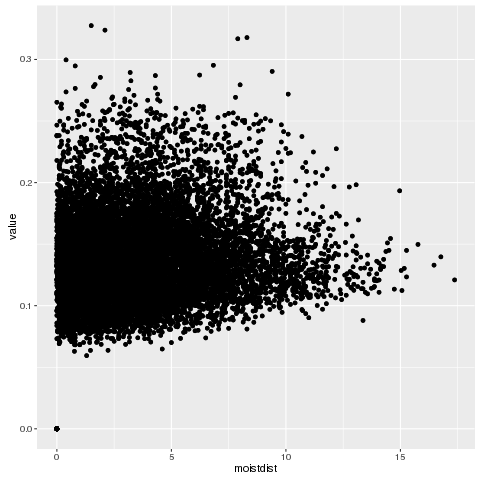

In [14]:
%%R
ggplot(data = df.tot, aes(x = moistdist, y = value)) + geom_point()

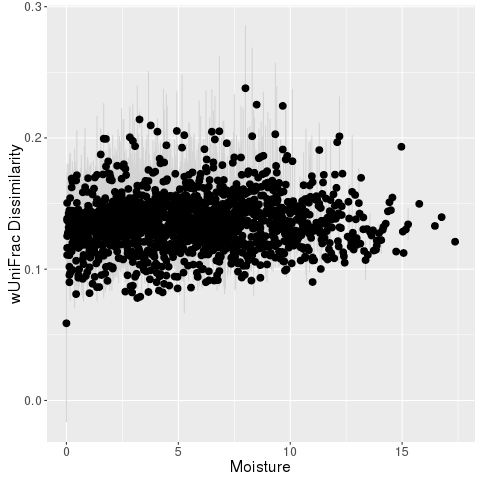

In [43]:
%%R

mean.tempdist = df.tot %>% group_by(moistdist) %>% summarise(meanval = mean(value), sdval = sd(value))

limits <- aes(ymax = meanval + sdval, ymin = meanval - sdval)

p = ggplot(data = mean.tempdist, aes(moistdist, meanval)) + geom_errorbar(limits, color = 'light grey')+ 
        geom_point(size = 3) +
    xlab('Moisture') + ylab('wUniFrac Dissimilarity') + 
    theme(text = element_text(size = 16)) 
p

In [44]:
%%R
ggsave('data/figs/bact_Moisture_dist.jpg', width = 7, height = 5)

In [16]:
%%R
library(ecodist)
mantel(formula = wunif.dist.nopas ~ dist.Moist, nperm = 10000)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘ecodist’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:vegan’:

    mantel


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:phyloseq’:

    distance


  res = super(Function, self).__call__(*new_args, **new_kwargs)


   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.06890024 0.06110000 0.93900000 0.09970000 0.04208295 0.09327825 


## Split into Treatment

In [17]:
%%R
tbl.meta = physeq.Bulk.core %>% sample_data
u.lm = tbl.meta$Land_Management %>% unique
u.lm

[1] NTR NTH PTR PTH
Levels: NTH NTR PTH PTR


In [18]:
%%R
physeq.Treat.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Land_Management == d)
    physeq.Treat.l[[d]] = tmp
    print(d)
    physeq.Treat.l[[d]] %>% print
    }

[1] "NTR"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]
[1] "NTH"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]
[1] "PTR"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 39 samples ]
sample_data() Sample Data:       [ 39 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]
[1] "PTH"
phyloseq-class 

In [19]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    
    MH.dist = phyloseq::distance(physeq, 
                      method = 'unifrac', 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
    return(MH.dist)
    }

MH.dist.treat.l = lapply(physeq.Treat.l, calc.MH.dist, cores=nprocs)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Processing sample...

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [20]:
%%R
#Sample metadata for split physeq objects
physeq.Treat.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Land_Management == d)
    physeq.Treat.meta[[d]] = sample_data(tmp)
    }


In [21]:
%%R
treatments = c('NTR', 'NTH', 'PTR', 'PTH')
str(treatments)

 chr [1:4] "NTR" "NTH" "PTR" "PTH"


In [22]:
%%R

join_temp = function(treatment, dist.mat, metadata, moistdata){
    
    m = data.frame(metadata[[treatment]])
    dist = dist.mat[[treatment]]
    moist = filter(moistdata, Land_Management == treatment)
    
    #creating matrix of Morisita-horn distances
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    
    #adding metadata to temperature phlyoseq object
    m$MY = paste(m$Month, m$Year, sep = '-')
    
    #Creating temperature distance matrix
    moistdata = dist(moist$Soil_Moisture)
    df.T = melt(as.matrix(moistdata, varnames = c('T1', 'T2')))
    
    #Adding sample information
    df.T$tempdist = df.T$value
    df.T$T1 = df.melt$T1
    df.T$T2 = df.melt$T2

    #Removing other variables
    df.T$value = NULL
    df.T$Var1 = NULL
    df.T$Var2 = NULL
    
    
    df.tot = left_join(df.melt, df.T)
    df.tot$Treatment = treatment

  
    return(df.tot)
    
    
}


temp.data = lapply(treatments, join_temp, metadata = physeq.Treat.meta, 
                   dist.mat = MH.dist.treat.l,moistdata = SD)

In [23]:
%%R

##Need to figure out how to include multiple lists in the function itself...
join_temp = function(treatment, moistdata){
        
    moist = filter(moistdata, Land_Management == treatment)
    moistdata = dist(moist$Soil_Moisture)
    
    return(moistdata)

    
    
}


temp.dist = lapply(treatments, join_temp, moistdata = SD)

In [24]:
%%R

plot_by_treatment = function(df.tempdist) {
    
   treatment = unique(df.tempdist$Treatment)

    df.tempdist$tempdist = round(df.tempdist$tempdist, digits = 3)
    
   mean.tempdist = df.tempdist %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Moisture difference') + ylab('wUniFrac Dissimilarity') + 
    theme(text = element_text(size = 16)) + ggtitle(treatment)

return(p) 
    
}

plots = lapply(temp.data, plot_by_treatment)

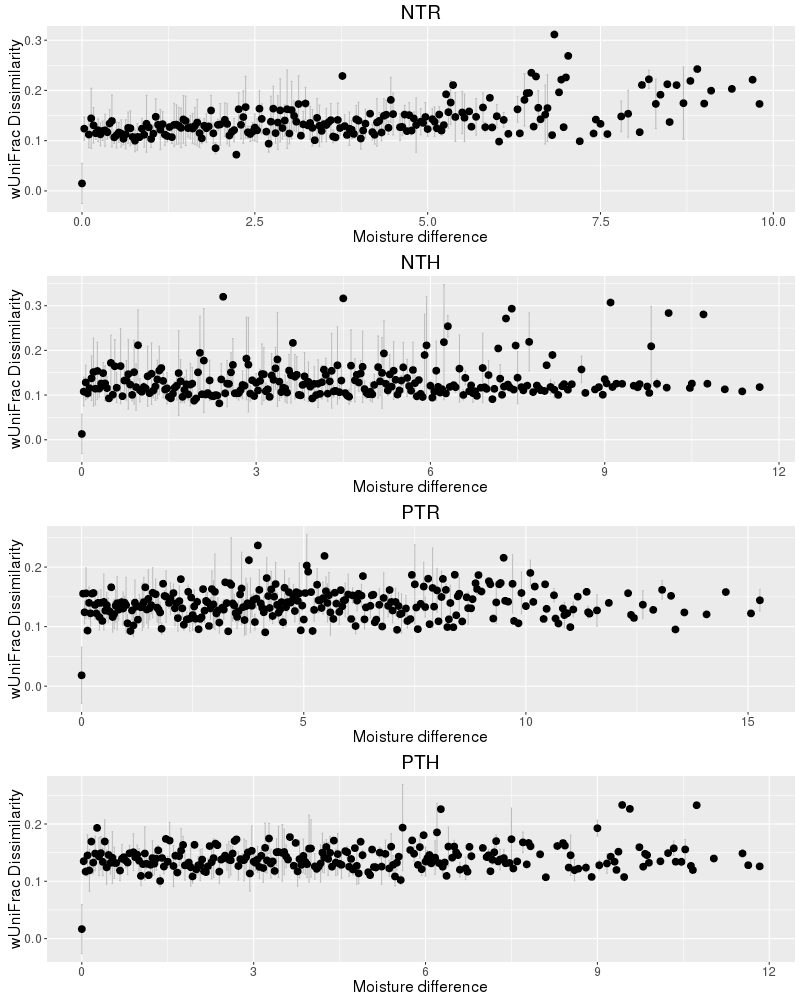

In [25]:
%%R -w 800 -h 1000
do.call(grid.arrange, c(plots,list(ncol=1)))

In [26]:
%%R
mantel.Temp = function(treatment, df.temp, df.dist) {
    
    df.t = df.temp[[treatment]]
    df.d = df.dist[[treatment]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.temp = lapply(c(1,2,3,4), df.temp = temp.dist, df.dist = MH.dist.treat.l, mantel.Temp)

In [27]:
%%R
head(m.temp)

[[1]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.3581816  0.0003000  0.9998000  0.0003000  0.2587352  0.4517817 

[[2]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.06577913 0.21470000 0.78540000 0.46430000 0.01003698 0.11008220 

[[3]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.10421577 0.12950000 0.87060000 0.24770000 0.05232999 0.18536805 

[[4]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.08822130 0.13890000 0.86120000 0.26070000 0.03170145 0.13292891 



## Separation by Replicate - temp vs phylogenetic distance

In [28]:
%%R
u.lm = c(1,2,3,4)
u.lm

[1] 1 2 3 4


In [29]:
%%R
physeq.Rep.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.l[[d]] = tmp
    print(d)
    physeq.Rep.l[[d]] %>% print
    }

[1] "1"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 39 samples ]
sample_data() Sample Data:       [ 39 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]
[1] "2"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 38 samples ]
sample_data() Sample Data:       [ 38 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]
[1] "3"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 39 samples ]
sample_data() Sample Data:       [ 39 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]
[1] "4"
phyloseq-class experime

In [30]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq, 
                      method = 'unifrac', 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
    return(MH.dist)
    }

MH.dist.rep.l = lapply(physeq.Rep.l, calc.MH.dist, cores=nprocs)

In [31]:
%%R
#Sample metadata for split physeq objects
physeq.Rep.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.meta[[d]] = sample_data(tmp)
    }


In [32]:
%%R
replicates = c(1,2,3,4)
str(replicates)

 num [1:4] 1 2 3 4


In [33]:
%%R

join_temp = function(replicate, dist.mat, moistdata){
    
    dist = dist.mat[[as.character(replicate)]]
    moist = filter(moistdata, Replicate == replicate)
    #creating matrix of Morisita-horn distances
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))  
    #Creating moisture distance matrix
    moist2 = dist(moist$Soil_Moisture)
    df.T = melt(as.matrix(moist2, varnames = c('T1', 'T2')))
    #Adding sample information
    df.T$tempdist = df.T$value
    df.T$T1 = df.melt$T1
    df.T$T2 = df.melt$T2

    #Removing other variables
    df.T$value = NULL
    df.T$Var1 = NULL
    df.T$Var2 = NULL
    
    
    df.tot = left_join(df.melt, df.T)
    df.tot$Replicate = replicate

  
    return(df.tot)
    
    
}


temp.data = lapply(replicates, join_temp, 
                   dist.mat = MH.dist.rep.l, moistdata = SD)

In [34]:
%%R
str(temp.data)

List of 4
 $ :'data.frame':	1521 obs. of  5 variables:
  ..$ T1       : Factor w/ 39 levels "Oct.NTR.1.2015",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ T2       : Factor w/ 39 levels "Oct.NTR.1.2015",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ value    : num [1:1521] 0 0.107 0.127 0.146 0.124 ...
  ..$ tempdist : num [1:1521] 0 6.333 0.967 3.167 0.467 ...
  ..$ Replicate: num [1:1521] 1 1 1 1 1 1 1 1 1 1 ...
 $ :'data.frame':	1444 obs. of  5 variables:
  ..$ T1       : Factor w/ 38 levels "S.NTR.2","June15.NTH.2",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ T2       : Factor w/ 38 levels "S.NTR.2","June15.NTH.2",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ value    : num [1:1444] 0 0.177 0.218 0.173 0.193 ...
  ..$ tempdist : num [1:1444] 0 9.1 3.9 7.3 3.47 ...
  ..$ Replicate: num [1:1444] 2 2 2 2 2 2 2 2 2 2 ...
 $ :'data.frame':	1521 obs. of  5 variables:
  ..$ T1       : Factor w/ 39 levels "Sept.PTR.3.2015",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ T2       : Factor w/ 39 levels "Sept.PTR.3.2015",..: 1 1 1 1 1 1 1 1 1 1 ...
 

In [35]:
%%R

##Need to figure out how to include multiple lists in the function itself...
join_rep = function(physeq.meta){
        
    moistdata = dist(physeq.meta$Soil_Moisture)
    
    return(moistdata)

    
    
}


temp.dist = lapply(physeq.Rep.meta, join_rep)

In [36]:
%%R

plot_by_replicate = function(df.tempdist) {
    
    replicate = unique(df.tempdist$Replicate)

    df.tempdist$tempdist = round(df.tempdist$tempdist, digits = 3)
    
    mean.tempdist = df.tempdist %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

    p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Moisture difference') + ylab('wUniFrac Dissimilarity') + 
    theme(text = element_text(size = 16)) + ggtitle(replicate)

return(p) 
    
}

plots = lapply(temp.data, plot_by_replicate)

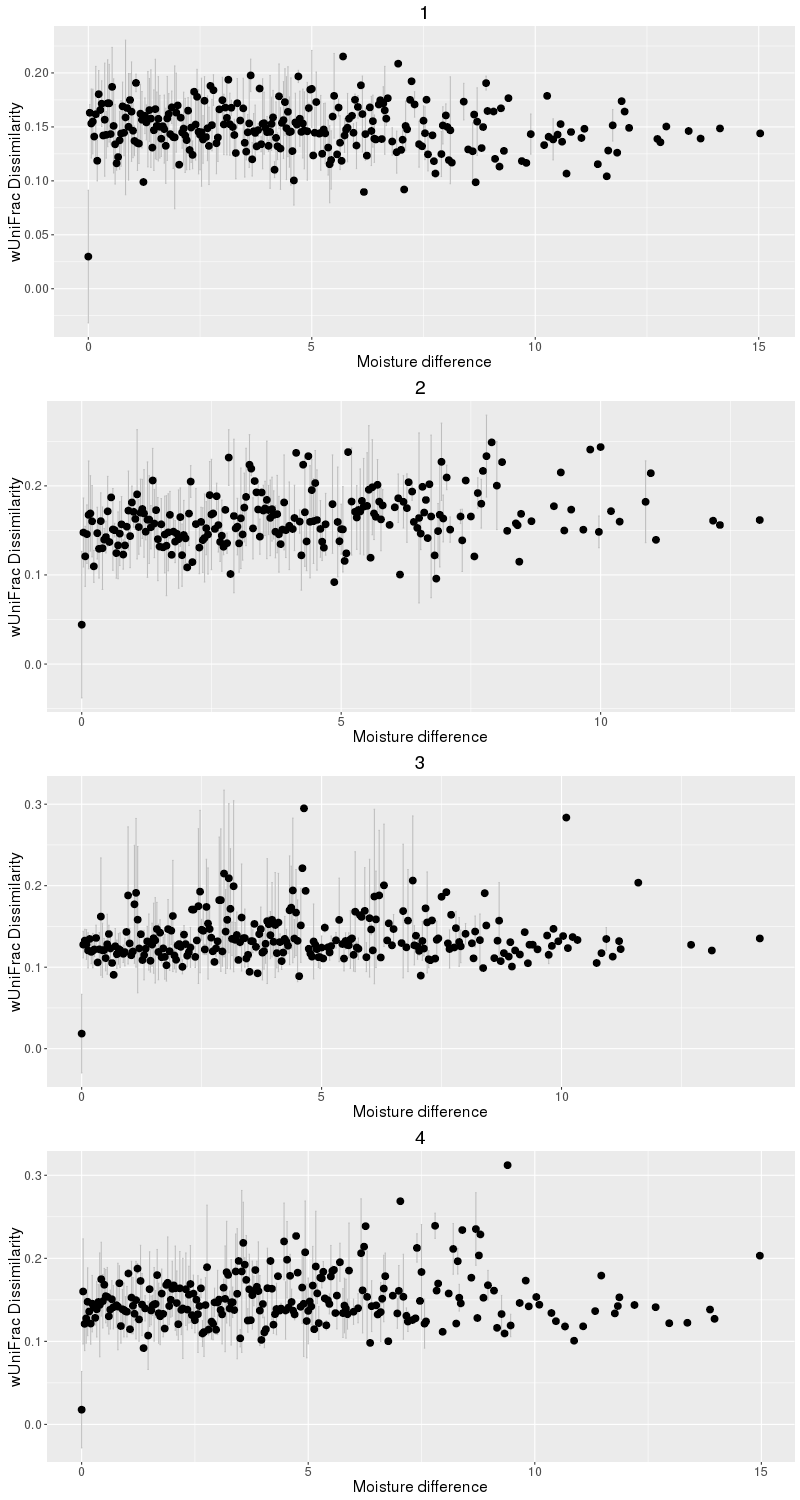

In [37]:
%%R -w 800 -h 1500
do.call(grid.arrange, c(plots,list(ncol=1)))

In [38]:
%%R
mantel.Temp = function(replicate, df.temp, df.dist) {
    
    df.t = df.temp[[as.character(replicate)]]
    df.d = df.dist[[as.character(replicate)]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.temp = lapply(replicates, df.temp = temp.dist, df.dist = MH.dist.rep.l, mantel.Temp)

In [39]:
%%R
#Results - replicates 4, 3, 1, 2
m.temp

[[1]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
-0.07629165  0.87220000  0.12790000  0.25510000 -0.11097128 -0.03361200 

[[2]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.1907771  0.0225000  0.9776000  0.0232000  0.1322540  0.2628998 

[[3]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.06770870 0.19820000 0.80190000 0.47240000 0.02986182 0.12306541 

[[4]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.10854812 0.13000000 0.87010000 0.22500000 0.05025394 0.19422011 

